In [1]:
from IPython.display import Image, display

from langchain_mcp_adapters.client import MultiServerMCPClient

from react_agent.src.agents.react_agent import ReActAgent
from react_agent.src.agents.triage import Triage

from react_agent.src.config.system_parameters import TriageSettings

from react_agent.src.util.tools_fabric import ToolsFabric

In [2]:
USE_MCP = False
DEBUG_MODE = True
USE_TRIAGE = False

In [3]:
mapping_question = "Explain how 'Payment Terms' is mapped. Start with 'map_invoice1'."
extensibility_question = "As a Public Cloud customer in Spain, can I extend an existing eDocument customer invoice Process?"
peppol_support = "We as Syntax are currently implementing SAP DRC and are following the official SAP help. We are currently at the step “Integration of Peppol Exchange with SAP S/4HANA Cloud” and there at the creation of an S/4HANA Public Cloud communication user. A client certificate should be uploaded for the communication user to be created, as Basic Auth (via user + password) is not supported. The problem: We do not have this certificate. Where can I get this certificate? What format must it be in? We are stuck at this step because we are missing the certificate mentioned and it is also not clear to us what kind of certificate is meant here and where to get it."
france_us = "As a localization developer, I want to enhance the relevancy check in the France eDocument country class with the new source type so that settlement management documents become relevant for the eDocument process and eDocuments are created for the source documents. How can I Achieve this?"

QUERY = france_us

In [4]:
if USE_TRIAGE:
    triage_agent = Triage()

    query_categorization = triage_agent.triage_user_message(user_message=QUERY)
    if DEBUG_MODE:
        print(f"query categorization: {query_categorization}")

In [5]:
if USE_TRIAGE:
    tools = ToolsFabric.get_tools_for_category(
        use_mcp=USE_MCP,
        configuration=query_categorization["category"],
    )
else:
    tools = ToolsFabric.get_tools_for_category(
        use_mcp=USE_MCP,
        configuration=TriageSettings.Categories.ALL,
    )

## Role
You are an expert in Electronic Document Processing, with deep domain knowledge in SAP Document and Reporting Compliance, Peppol, UBL, and eInvoicing standards.

## Objective
Use a reason-and-act (ReAct) approach to answer user questions with clear, well-supported reasoning chains, and tool-validated outputs. Final answers must reflect insights derived from specific tool calls.

## Instructions
1. PLAN:
   - Restate the user's request in your own words.
   - Sketch a high-level approach: which tools you'll call and why.
2. EXECUTE:
   - Call the highest-ranked relevant tool first.
   - Wait for the tool to return its output, then immediately proceed to either VERIFY or SUMMARIZE.
   - Use strict sequential execution: only one tool call per reasoning cycle.
   - Record the tool's raw output (no paraphrase).
3. VERIFY:
   - If the output is ambiguous or high-impact (e.g. compliance rules), call a second, independent tool.
   - Compare both results. If they conflict, prefer the ou

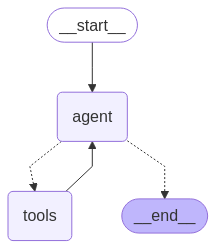

================================ Human Message =================================

As a localization developer, I want to enhance the relevancy check in the France eDocument country class with the new source type so that settlement management documents become relevant for the eDocument process and eDocuments are created for the source documents. How can I Achieve this?
================================== Ai Message ==================================
Tool Calls:
  sap_documentation_summary (call_oEG2KRl9nWHRJNWdOji2ANyb)
 Call ID: call_oEG2KRl9nWHRJNWdOji2ANyb
  Args:
    query: France eDocument relevancy check source type settlement management EDOC_FR eDocument Document and Reporting Compliance
================================= Tool Message =================================
Name: sap_documentation_summary

The Document and Reporting Compliance (DRC) system, also known as DRCce, Foundation Layer, or Communication Layer, is designed to help companies create, process, and monitor electronic

In [6]:
if USE_MCP:
    async with MultiServerMCPClient(tools) as client:
        agent = ReActAgent(tool_list=client.get_tools())
        if DEBUG_MODE:
            print(agent.create_sys_prompt())
            display(Image(agent.get_agent_graph()))

        await agent.arun_agent_with_input(user_message=QUERY, debug=DEBUG_MODE)
else:
    agent = ReActAgent(tool_list=tools)
    if DEBUG_MODE:
        print(agent.create_sys_prompt())
        display(Image(agent.get_agent_graph()))

    agent.run_agent_with_input(user_message=QUERY, debug=DEBUG_MODE)

In [7]:
run_data = agent.get_execution_data()

run_data.pretty_print()

Agent Run Summary
Model Used:
o3

Execution Time: 
72.856 seconds

Token Consumption Statistics
  Input Tokens: 23486
  Output Tokens: 2392
  Total Tokens: 25878

LLM call count: 7

Tools Used:
  Tool #1:
    Name: sap_documentation_summary
    Arguments:
      query: France eDocument relevancy check source type settlement management EDOC_FR eDocument Document and Reporting Compliance
  Tool #2:
    Name: abap_method_codebase_search
    Arguments:
      query: France relevancy check settlement management
  Tool #3:
    Name: abap_method_codebase_search
    Arguments:
      query: fr relevancy check edoc
  Tool #4:
    Name: abap_method_codebase_search
    Arguments:
      query: cl_edocument_fr
  Tool #5:
    Name: abap_method_codebase_search
    Arguments:
      query: cl_edoc_source_stlmt
  Tool #6:
    Name: abap_method_codebase_search
    Arguments:
      query: METHOD is_relevant.  METHOD cl_edocument


In [8]:
print(run_data.final_output)

Technical explanation (what you really have to do)  
1. Customising – tell the framework that settlement-management (STLMT) documents are allowed for France
   • View EDOCOMPANYACTIV  
     – Add one line per French company code  
     – Source type = STLMT_INV (constant CL_EDOC_SOURCE_STLMT=>GC_SRC_STLMT_INV)  
     – Active = X  
   • View EDOTMFK (Assign eDocument Type to Settlement-Management Billing Type)  
     – Country = FR  
     – LFART (settlement billing type) → the French eDocument type you want to create (for example FR_INV or FR_CRED).  
   Without this table content the France classes will never regard the document as relevant, even after the code change.

2. Code – extend the relevancy routine of the France country class with the new source type  
   • Target method: CL_EDOCUMENT_FR (or the more specific subclass you use, e.g. CL_EDOCUMENT_FR_INV) → IS_RELEVANT.  
   • Create an implicit enhancement-point or a subclass and REDEFINE the method; call the super implementa